In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import scipy.optimize as optimize

# Default Plotting

In [2]:
x = [1.00154928e+00, 1.99732972e+00, 5.02515674e+00, 1.00615129e+01,
     2.00602924e+01, 5.00009258e+01, 1.00007821e+02, 5.00017613e+02,
     9.99965619e+02, 2.00000891e+03, 5.00018485e+03, 1.00001941e+04,
     2.00012565e+04, 4.99962847e+04, 1.00000584e+05, 1.99999695e+05]
y = [-80.48868855, -59.30140999, -51.50728884,  -2.94024048,   24.9916095,
       61.6853314, 138.30890713,  158.87064769, 186.72384523, 230.47443632,
     288.92892663, 314.42971124,  384.82014922, 455.44935458, 456.77311967,
     478.20998969]

In [3]:
def linear_func(x,a,b):
    return a*x+b

def adjr_squared(y, y_pred,p):
    residuals = y - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    n = len(y)
    r_squared = 1 - ((ss_res/(n-p)) / (ss_tot/(n-1)))

    return r_squared

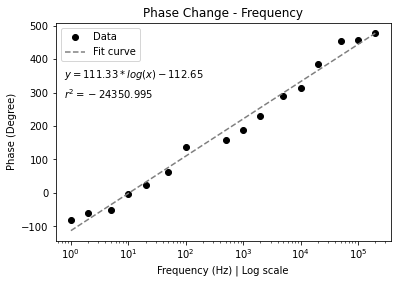

In [4]:

popt, pcov = optimize.curve_fit(linear_func, np.log10(x), y)
plt.plot(x,y, "ko", label="Data")
plt.plot(x, linear_func(np.log10(x), *popt), "gray", linestyle="--", label="Fit curve")
plt.xscale("log")
plt.title("Phase Change - Frequency")
plt.xlabel("Frequency (Hz) | Log scale")
plt.ylabel("Phase (Degree)")
r_2 = adjr_squared(np.log10(x), y, 1)
plt.text(0.025, 0.75, f'$y = {popt[0]:.2f}*log(x){popt[1]:.2f}$',  transform=plt.gca().transAxes)
plt.text(0.025, 0.65, f'$r^2 = {r_2:0.3f}$', transform=plt.gca().transAxes)
plt.legend()


# Error Bar Plotting

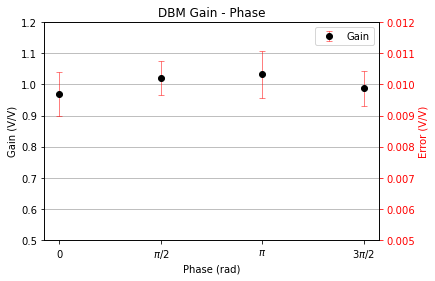

In [5]:
def linear_func(x,a,b):
    return a*x+b

gain = [1.9395, 2.0394,2.0649,1.9742]
err = [0.0014,0.0011, 0.0015,0.0011]
x = [0, np.pi/2, np.pi, np.pi*3/2]
y = np.array(gain)/2

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ratio = 100
ax1.errorbar(x, y,
            yerr=ratio*np.array(err)/2, # Y-errors
            fmt="ko", # format line like for plot()
            linewidth=2, # width of plot line
            elinewidth=0.5,# width of error bar line
            ecolor='r', # color of error bar
            capsize=3, # cap length for error bar
            capthick=0.5, # cap thickness for error bar
            label="Gain")
ax1.set_title("DBM Gain - Phase")
ax1.set_xlabel("Phase (rad)")
ax1.set_ylabel("Gain (V/V)")
ax1.set_ylim(0.5,1.2)
ax1.set_xticks([0, np.pi/2, np.pi, np.pi*3/2])
ax1.set_xticklabels(['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$'])
ax2.set_ylim(0.5/ratio,1.2/ratio)
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel("Error (V/V)", color='r')

ax1.legend()
ax1.grid(axis="y")
plt.show()

# 3D Plotting

In [6]:
def lorenztian(x, A, sigma, mu):
    return A/np.pi * (sigma/((x-mu)**2+sigma**2))

def double_lorenztian(x, a1, s1, m1, a2, s2, m2, y0):
    return lorenztian(x, a1,s1,m1)+lorenztian(x,a2,s2,m2)+y0

In [7]:
import scipy.signal as sig

In [8]:
def PL_analysis(df, guess=None, view_range=30, merge = None, plt_output=False, temp=0, bounds=True, save=False):
    
    x = df.A.values
    y = df.B.values
    max_idx = np.argmax(y)
    
    x = x[max_idx-view_range : max_idx+view_range].copy()
    y = y[max_idx-view_range : max_idx+view_range].copy()
    
    peaks, _ = sig.find_peaks(y, width=2)

    s = np.argsort(y[peaks])
    y_pk = y[peaks][s].copy()[::-1].copy()
    x_pk = x[peaks][s].copy()[::-1].copy()
  
    s1 = 0.05; a1 = y_pk[0]*np.pi*0.05; x1 = x_pk[0]
    s2 = 0.05; a2 = y_pk[1]*np.pi*0.05; x2 = x_pk[1]
    
    
    p0=[a1,s1,x1,a2,s2,x2,0]
    
    bounds = ((0, 0, 690, 0, 0, 690, 0),(1000, 1, 699, 500, 1, 699, 1000))

    popt, pcov = scipy.optimize.curve_fit(double_lorenztian, x, y, p0=p0, method="trf",
                                          bounds = bounds,
                                          ftol=1e-15, xtol=1e-15, gtol=1e-15, max_nfev=5000, 
                                          x_scale = [1, 0.0001, 0.01, 1, 0.0001, 0.01,1])

    
    xlins = np.linspace(np.min(x),np.max(x),1000)
    fig1 = plt.plot(x,y)
    fig2 = plt.plot(xlins, double_lorenztian(xlins, *popt))

    return fig1, fig2

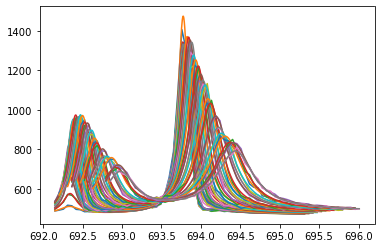

In [9]:
exp_data = []
fit_data = []

for i in range(1,30):
    inx = 10*i
    file_path = f"./PL/ruby {inx}K.asc"
    df_results = pd.read_csv(file_path,sep="\t",names=['A', 'B'],skiprows=40,usecols=range(2),header=None)
    fig1, fig2 = PL_analysis(df_results)
    
    exp_data.append(fig1)
    fit_data.append(fig2)

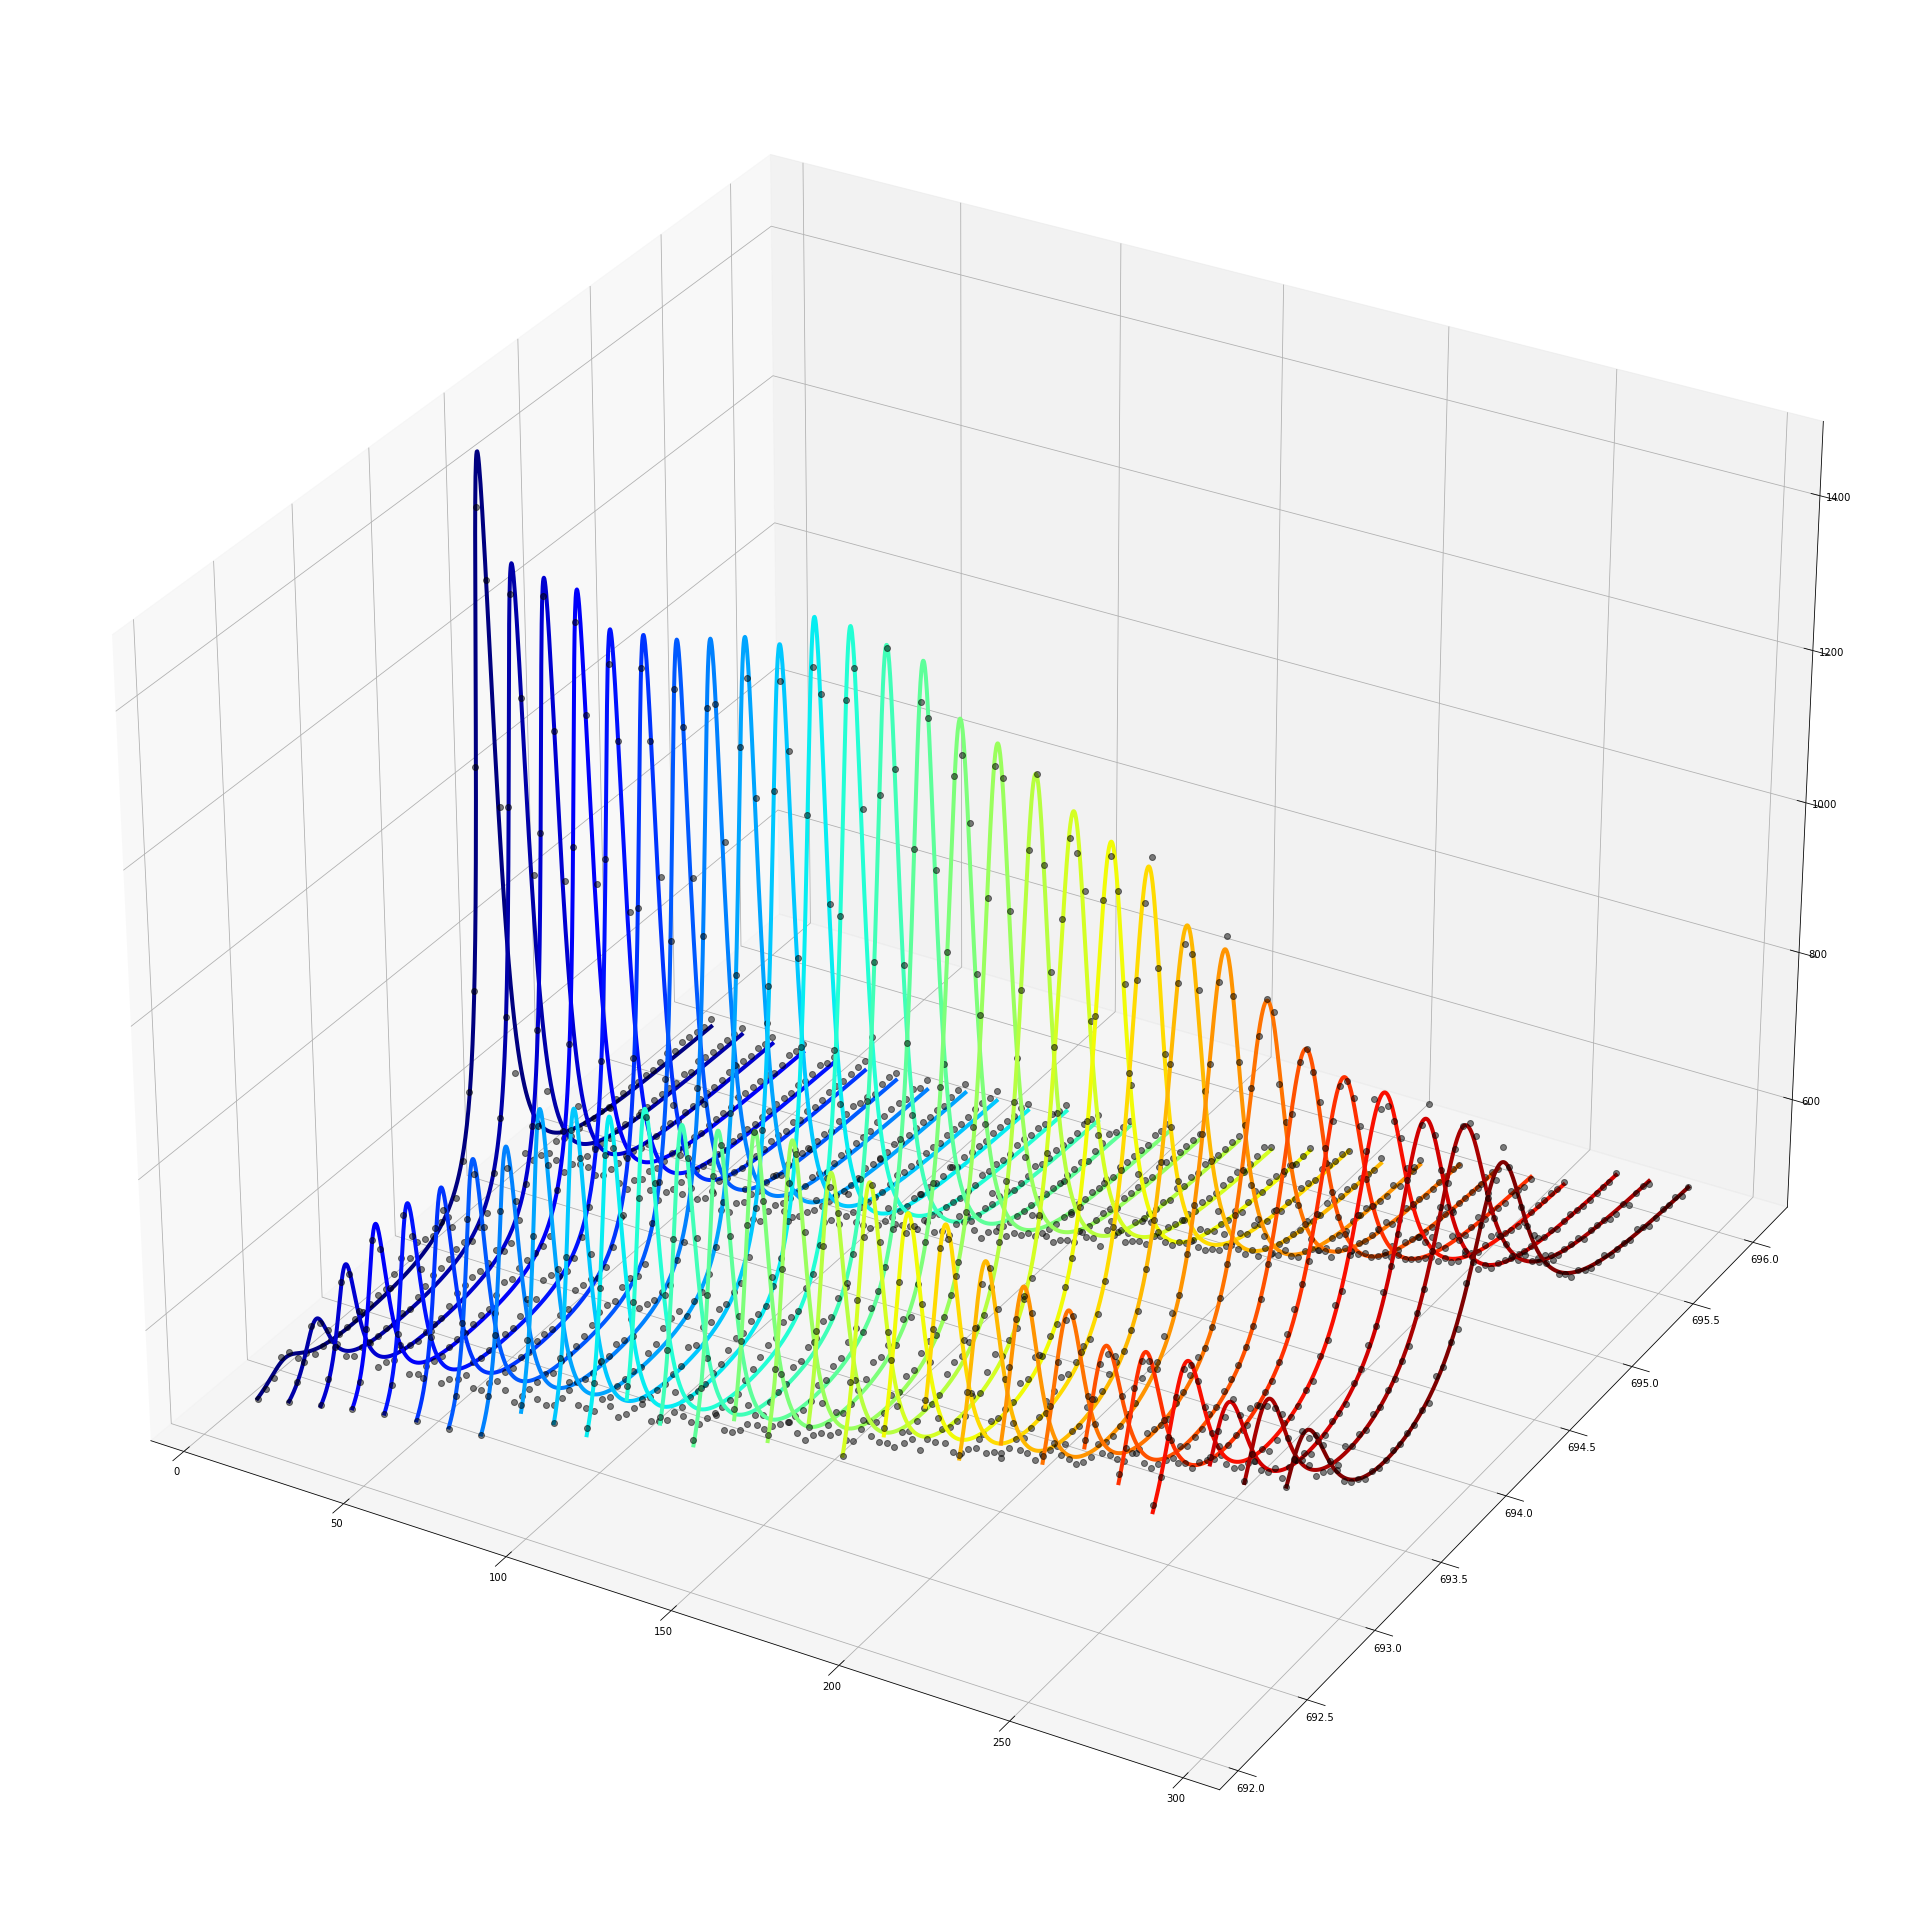

In [10]:
fig = plt.figure(figsize=(35,35))
ax = fig.gca(projection='3d')

c_list = [plt.cm.jet(a) for a in np.linspace(0.0, 1.0, 29)]
for i in range(29):
    temp = (i+1)*10
    fit_x = np.ones(shape=(len(fit_data[i][0].get_data()[0]),))
    exp_x = np.ones(shape=(len(exp_data[i][0].get_data()[0]),))

    ax.plot(temp*fit_x,*fit_data[i][0].get_data(),
            color=c_list[i], label=f"{temp}K PL data", lw=4)
    ax.plot(temp*exp_x,*exp_data[i][0].get_data(), "ko", alpha=0.5)



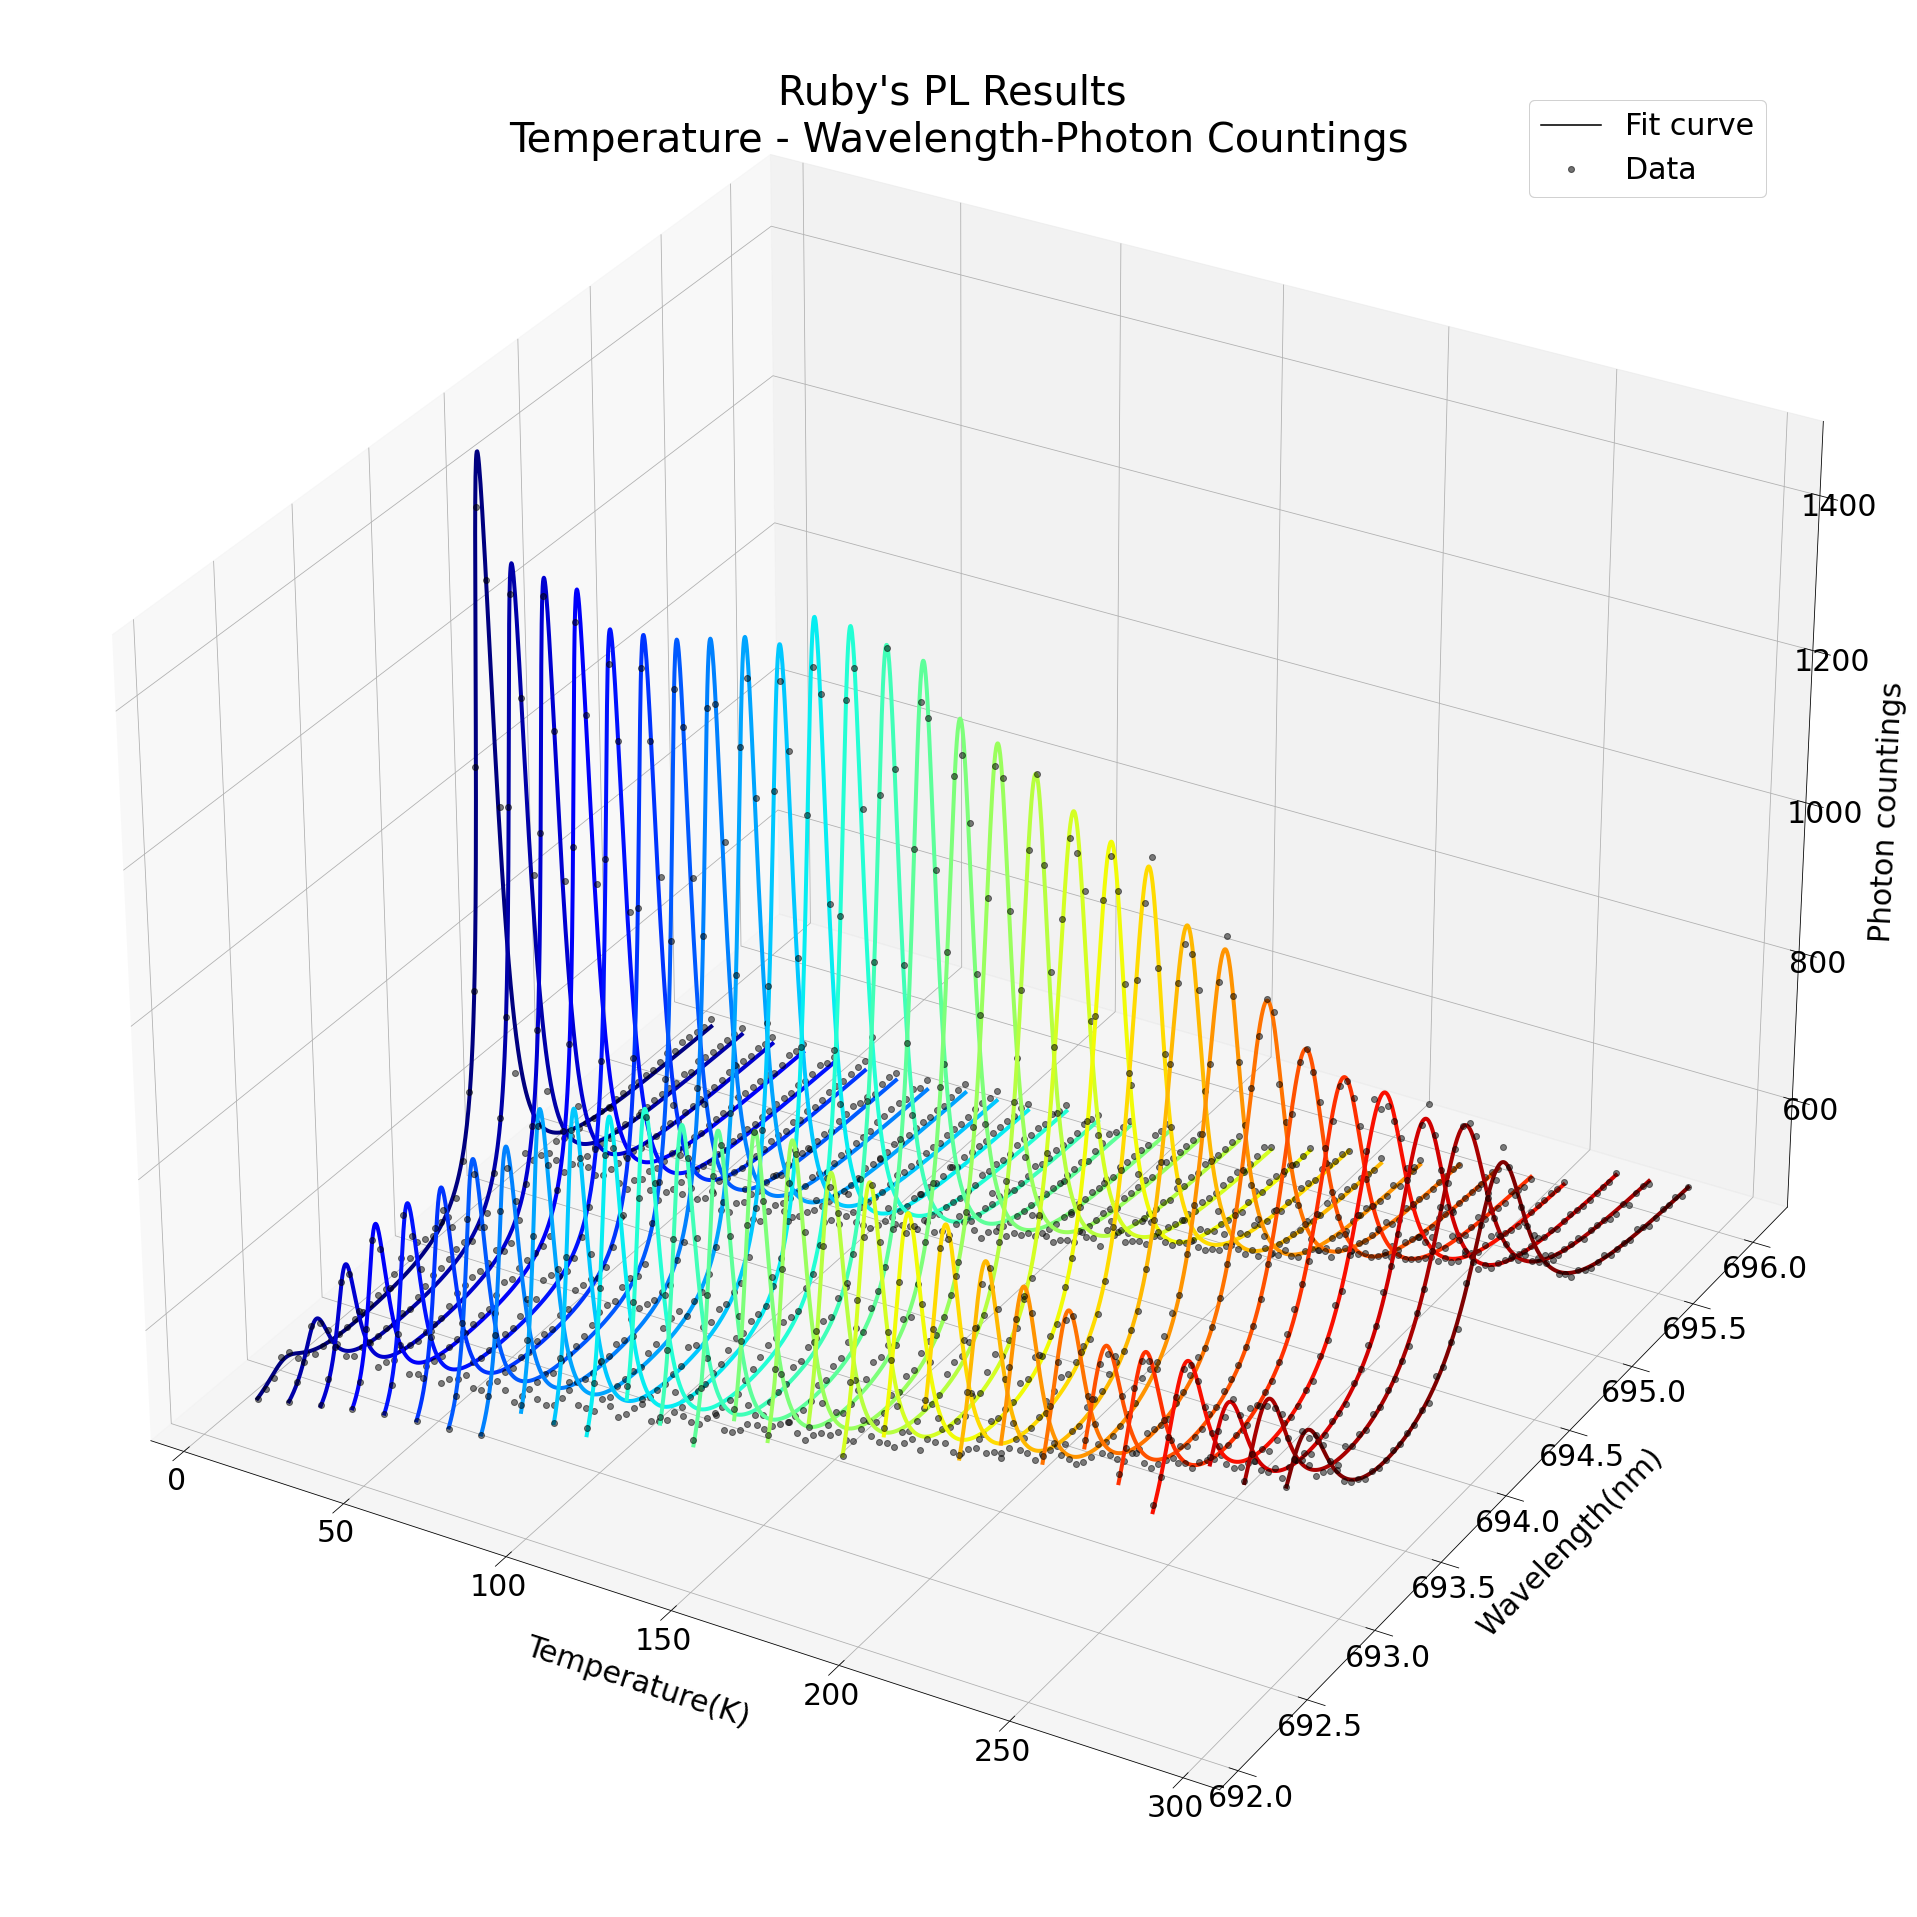

In [11]:
ax = fig.gca()
ax.set_zlabel('Photon countings', labelpad=30,fontsize=30)
ax.set_ylabel('Wavelength(nm)', labelpad=30,fontsize=30)
ax.set_xlabel('Temperature(K)', labelpad=30,fontsize=30)
ax.tick_params(axis='x', labelsize =30)
ax.tick_params(axis='y', labelsize =30)
ax.tick_params(axis='z', labelsize =30)

ax.set_title("Ruby's PL Results \nTemperature - Wavelength-Photon Countings", loc='center', y=1.001, fontsize=40)

import matplotlib.lines as mlines

_line = mlines.Line2D([], [], color='k', linestyle='-', label='Fit curve')
_marker = mlines.Line2D([], [], color='k', marker='o', linestyle="None", alpha=0.5, label='Data')
legend_ = ax.legend(handles=[_line, _marker], loc=(0.8,0.9),fontsize = 30)
ax.add_artist(legend_)

fig

# Plot with Zoomed Plot

In [12]:
from uncertainties import ufloat
import numba

In [13]:
sigma_avg = ufloat(8.38e-10, 0.35e-10)
mu_avg = ufloat(5.8e-7, 1.2e-7)

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [15]:
def plot_lorenztian(sigma_avg, mu_avg):
    def lorenztian(lamb,I,sigma,mu):
        return I*sigma**2/((lamb-mu)**2+sigma**2)

    FWHM = 2*sigma_avg.n
    
    fig, ax = plt.subplots()
    x = np.linspace(mu_avg.n-10*10**(-9) ,mu_avg.n+10*10**(-9),500)
    x_FWHM = np.linspace(mu_avg.n-FWHM/2, mu_avg.n+FWHM/2, 500)
    y = lorenztian(x,1,sigma_avg.n, mu_avg.n)
    
    ax.plot(x*10**(9), y, 'k',label="Spectral Strength")
    ax.fill_between(x_FWHM*10**9,
                    lorenztian(x_FWHM,1,sigma_avg.n, mu_avg.n),
                    alpha=0.5, color='k',label="FWHM")
    ax.fill_between(x*10**9,
                    lorenztian(x,1,sigma_avg.n-sigma_avg.s, mu_avg.n), 
                    lorenztian(x,1,sigma_avg.n+sigma_avg.s, mu_avg.n),
                    alpha=0.25, color='k',label="Interval")
    
    axins = zoomed_inset_axes(ax, zoom = 3, loc=7)
    
    axins.plot(x*10**(9), y, 'k',label="Spectral Strength")
    axins.fill_between(x_FWHM*10**9,
                       lorenztian(x_FWHM,1,sigma_avg.n, mu_avg.n),
                       alpha=0.5, color='k',label="FWHM")
    axins.fill_between(x*10**9,
                       lorenztian(x,1,sigma_avg.n-sigma_avg.s, mu_avg.n), 
                       lorenztian(x,1,sigma_avg.n+sigma_avg.s, mu_avg.n),
                       alpha=0.25, color='k',label="Interval")

    mark_inset(ax, axins, loc1=4, loc2=2, fc="None", ec="k")
    
    axins.set_xlim(mu_avg.n*10**9+ sigma_avg.n*10**9, mu_avg.n*10**9+ sigma_avg.n*10**9+2)
    axins.set_ylim(0.2, 0.35)
    axins.set_xticks([])
    axins.set_yticks([])


    ax.set_xlabel(r"$WaveLength (nm)$")
    ax.set_ylabel(r"$Strength\ Ratio$")    
    ax.set_title("Bulb Spectral Strength")
    ax.set_xlim((mu_avg.n-10*10**(-9))*10**9, (mu_avg.n+10*10**(-9))*10**9)
    ax.legend(loc="upper right")

    plt.show()

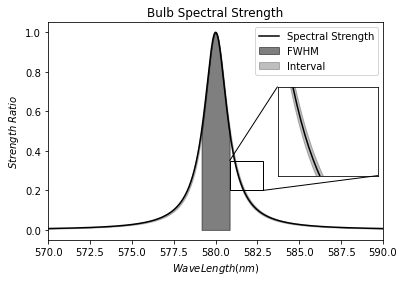

In [16]:
plot_lorenztian(sigma_avg, mu_avg)